# Train Model



## Set parameters that will control the execution

In [1]:
data_dir = "../_DATA/CarND/p3_behavioral_cloning/set_000/"
image_dir = "IMG/"
driving_data_csv = "driving_log_original.csv"
YIELD_BATCH_SIZE = 16 #256
RUN_EPOCHS = 5 

should_retrain_existing_model = False
saved_model = "model_epoch_33_val_acc_0.0.h5"
previous_trained_epochs = 0

In [2]:
import DataHelper

Using TensorFlow backend.


# Allocate only a fraction of memory to TensorFlow GPU process

In [3]:
# https://github.com/aymericdamien/TensorFlow-Examples/issues/38#issuecomment-265599695
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9) # try range from 0.3 to 0.9
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

#### Show available CPU and GPU(s)
from tensorflow.python.client import device_lib
def get_available_CPU_GPU():
    devices = device_lib.list_local_devices()
    #return [x.name for x in devices if x.device_type == 'CPU']
    return [x.name for x in devices ]

print(get_available_CPU_GPU())

['/cpu:0', '/gpu:0']


# Fetch data from CSV file

In [4]:
from  DataHelper import read_csv
csv_path = data_dir + driving_data_csv
print("csv_path", csv_path)
headers, data = read_csv(data_dir + driving_data_csv)

csv_path ../_DATA/CarND/p3_behavioral_cloning/set_000/driving_log_original.csv
Number of imported CSV rows: 8037


# Split data into training, testing and validation sets

In [5]:
from DataHelper import split_random
training, testing, validation = split_random(data, percent_train=75, percent_test=15) 

print("training", training.shape, type(training) )
print("testing", testing.shape, type(training))
print("validation", validation.shape, type(training))

percent_validation 10
training (6027, 7) <class 'numpy.ndarray'>
testing (1206, 7) <class 'numpy.ndarray'>
validation (803, 7) <class 'numpy.ndarray'>


# Fetch and visualize training steering angles

I would like to train a car on the set that has a nice bell curve distribution of values:
- I can drive the car on the track backwards
- I can flip each image (and value)

# Remove zero-steering angles from training set 

In [6]:
import numpy as np
from DataHelper import plot_histogram, get_steering_values, find_nearest

len(training) 6027
min_value -0.942695 max_value 1.0
spread 1.9427 in 195 bins


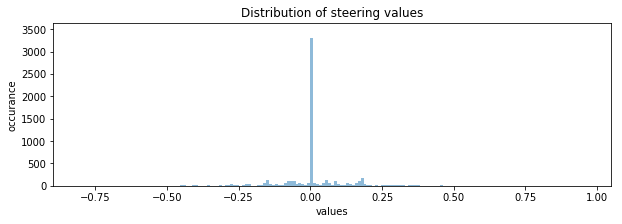

len(indexes_to_keep) 2724
len(training) 2724
min_value -0.942695 max_value 1.0
spread 1.9427 in 195 bins


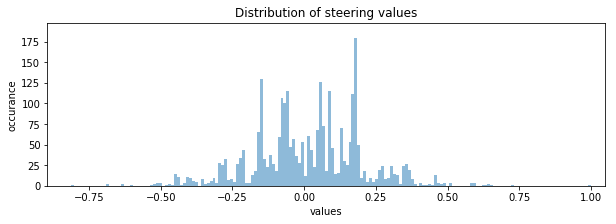

In [7]:
def remove_zeros(training):
    
    print("len(training)", len(training))
    indexes_to_keep = []
    
    steering_angles = get_steering_values(training)
    plot_histogram("steering values", steering_angles, change_step=0.01)

    for index in range (len(steering_angles)):
        angle = steering_angles[index]
        if angle != 0: 
            indexes_to_keep.append(index)

    print("len(indexes_to_keep)", len(indexes_to_keep))

    training_to_keep = []
    for index in indexes_to_keep:
        training_to_keep.append(training[index])

    training = training_to_keep
    # release the memory
    training_to_keep = []
    indexes_to_keep = []

    print("len(training)", len(training))

    steering_angles = get_steering_values(training)
    plot_histogram("steering values", steering_angles, change_step=0.01)
    return training

training = remove_zeros(training)

# Extract image names

In [8]:
def get_center_image_names(training):
    from DataHelper import get_image_center_values 
    image_names = get_image_center_values(training)
    return image_names

image_names = get_center_image_names(training)
print("image count", image_names.shape[0])
print(image_names[1])

image count 2724
IMG/center_2016_12_01_13_37_03_731.jpg


# Create a list of image paths

In [9]:
def build_image_paths(image_names):
    image_paths = []
    for image_name in image_names:
        image_paths.extend([data_dir + image_name])
    return image_paths

image_paths = build_image_paths(image_names)
print(image_paths[1]) 
print("found paths:", len(image_paths) ) 

../_DATA/CarND/p3_behavioral_cloning/set_000/IMG/center_2016_12_01_13_37_03_731.jpg
found paths: 2724


# Read actual images

In [10]:
def read_images(image_paths):
    import numpy as np 
    from ImageHelper import read_image_array
    #training_features = [read_image_array(path) for path in image_paths]

    image_list = []
    for path in image_paths:
        image_list.append(read_image_array(path))
    training_features = np.array(image_list) # numpy array, not just a list
    return training_features

image_paths[2] ../_DATA/CarND/p3_behavioral_cloning/set_000/IMG/center_2016_12_01_13_35_36_989.jpg
training_features count 2724
sample_image   (160, 320, 3)


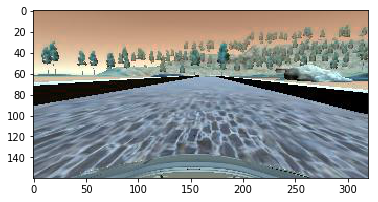

In [11]:
training_features = read_images(image_paths)

print ("image_paths[2]", image_paths[2] )
print ("training_features count", len(training_features) )

sample_image = training_features[2]
print ("sample_image  ", sample_image.shape)

import matplotlib.pyplot as plt
plt.imshow(sample_image) # cmap='gray' , cmap='rainbow'
plt.show()

#print(sample_image[0][0:15])

# Import Keras (layer above TensorFlow)

https://keras.io/layers/convolutional/

In [12]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import ELU, InputLayer, Input
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda
from keras.activations import relu, softmax
from keras.optimizers import SGD
import cv2, numpy as np
from DataHelper import mean_pred, false_rates
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Convolution1D

# Build a Convolutional Neural Network

## Minimal Model

In [13]:
# image_dimentions = (3, 80, 320)  # Trimmed image format

In [14]:
def get_CDNN_model_minimal(input_shape):
    model = Sequential()
    
    model.add(Lambda(lambda x: x/255.0 - 0.5, # normalize RGB 0-255 to -0.5 to 0.5
                     input_shape=input_shape))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation="relu", dim_ordering='tf'))
    #model.add(Convolution2D(32, 5, 5, border_mode='same', activation="relu" ))
    #model.add(Convolution2D(32, 5, 5, border_mode='same', activation="relu" ))
    model.add(Flatten())
    #model.add(MaxPooling2D(pool_size=(2, 2), name="MaxPool_2x2"))

    model.add(Dense(256, activation="relu")) #256
    model.add(Dropout(0.25, name="Dropout_0.25_01"))
    #model.add(Dense(256, activation="relu" )) #256

    # CLASSIFICATION
    #model.add(Dense(41, activation='linear' , name="dense_3_41_linear")) # default: linear | softmax | relu | sigmoid

    # REGRESSION
    model.add(Dense(1, activation='linear'))
    return model

# Compile model (configure learning process)

In [15]:
input_shape = (160, 320, 3) # sample_image   (160, 320, 3)
model = get_CDNN_model_minimal(input_shape)
model.summary()
# Before training a model, you need to configure the learning process, which is done via the compile method.
# 
# keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

optimizer="adam" # 'sgd' | 'rmsprop'
loss_function="mse" # | 'binary_crossentropy' | 'mse' | mean_squared_error | sparse_categorical_crossentropy
metrics_array=['accuracy'] # , mean_pred, false_rates

model.compile(optimizer, loss_function, metrics_array)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 160, 320, 32)  896         lambda_1[0][0]                   
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 1638400)       0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 256)           419430656   flatten_1[0][0]                  
___________________________________________________________________________________________

# Replace model with one stored on disk

- If you replace the model, the INPUT dimetions have to be the same as these trained
- Name your models well

# Define yield Generator

In [16]:
import numpy as np

def generator(example_set: np.ndarray, batch_size: int=32):
    """
    Yields batches of training or testing data every time the generator is called.
    I will use Keras to pre-process images (trim, resize)
    """
    import sklearn
    yield_number = 0
    while True:
        for offset in range(0, len(example_set), batch_size):
            
            sample_batch = example_set[offset:(offset + batch_size)]
            print(yield_number, ") from sample set of size=", len(example_set), 
                  "getting batch between", offset, "and", offset + batch_size,
                  "batch size=", len(sample_batch))
            
            labels = get_steering_values(sample_batch) 
            
            image_names = get_center_image_names(sample_batch) 
            image_paths = build_image_paths(image_names) 
            features = read_images(image_paths) 

            # I will use Keras to pre-process images (trim, resize)
            
            if len(features) != len(labels):
                print("ERROR: ", len(features), " features and ", len(labels), "labels count not matching!")
                #raise Exception("ERROR: ", len(features), " features and ", len(labels), "labels count not matching!")
            
            yield_number = yield_number = 1
            #sklearn.utils.shuffle( ) # I prefer not to mix them
            yield np.array(features), np.array(labels)

In [17]:
train_generator = generator(training, YIELD_BATCH_SIZE)
validation_generator = generator(testing, YIELD_BATCH_SIZE)

# Train (fit) the model agaist given labels

https://keras.io/models/sequential/


- steps_per_epoch: 
Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. It should typically be equal to the number of unique samples if your dataset divided by the batch size.

- initial_epoch: Epoch at which to start training (useful for resuming a previous training run)


In [18]:
history = model.fit_generator(train_generator,
                              samples_per_epoch = len(training), 
                              nb_epoch = RUN_EPOCHS, 
                              validation_data = validation_generator, 
                              nb_val_samples = len(validation), 
                              verbose = 0)

0 ) from sample set of size= 2724 getting batch between 0 and 16 batch size= 16
1 ) from sample set of size= 2724 getting batch between 16 and 32 batch size= 16
1 ) from sample set of size= 2724 getting batch between 32 and 48 batch size= 16
1 ) from sample set of size= 2724 getting batch between 48 and 64 batch size= 16
1 ) from sample set of size= 2724 getting batch between 64 and 80 batch size= 16
1 ) from sample set of size= 2724 getting batch between 80 and 96 batch size= 16
1 ) from sample set of size= 2724 getting batch between 96 and 112 batch size= 16
1 ) from sample set of size= 2724 getting batch between 112 and 128 batch size= 16
1 ) from sample set of size= 2724 getting batch between 128 and 144 batch size= 16
1 ) from sample set of size= 2724 getting batch between 144 and 160 batch size= 16
1 ) from sample set of size= 2724 getting batch between 160 and 176 batch size= 16


InternalError: Dst tensor is not initialized.
	 [[Node: Const_11 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [1638400,256] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'Const_11', defined at:
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-8ec29b593970>", line 6, in <module>
    verbose = 0)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/keras/models.py", line 935, in fit_generator
    initial_epoch=initial_epoch)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/keras/engine/training.py", line 1454, in fit_generator
    self._make_train_function()
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/keras/engine/training.py", line 760, in _make_train_function
    self.total_loss)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/keras/optimizers.py", line 428, in get_updates
    ms = [K.zeros(shape) for shape in shapes]
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/keras/optimizers.py", line 428, in <listcomp>
    ms = [K.zeros(shape) for shape in shapes]
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 491, in zeros
    return variable(tf.constant_initializer(0., dtype=tf_dtype)(shape),
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py", line 153, in __call__
    return constant_op.constant(self.value, dtype=dtype, shape=shape)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/tensorflow/python/framework/constant_op.py", line 169, in constant
    attrs={"value": tensor_value, "dtype": dtype_value}, name=name).outputs[0]
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Dst tensor is not initialized.
	 [[Node: Const_11 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [1638400,256] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [ ]:
# list all data in history
print(history.history.keys())

training_accuracy = str( history.history['acc'][nb_epoch-1])
print("training_accuracy", training_accuracy)

training_error = str( history.history['loss'][nb_epoch-1])
print("training_error", training_error)

validation_accuracy = str( history.history['val_acc'][nb_epoch-1])
print("validation_accuracy", validation_accuracy)

validation_error = str( history.history['val_loss'][nb_epoch-1])
print("validation_error", validation_error)

# Save the model

In [ ]:
# creates a HDF5 file '___.h5'
model.save(data_dir 
           + "model_epoch_" + str(nb_epoch + previous_trained_epochs) 
           + "_val_acc_" + str(validation_accuracy) 
           + ".h5") 
#del model  # deletes the existing model
#model = load_model('my_model.h5')

# summarize history for accuracy

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy (bigger better)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'testing accuracy'], loc='lower right')
plt.show()



# summarize history for loss

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation error (smaller better)')
plt.ylabel('error')
plt.xlabel('epochs run')
plt.legend(['training error(loss)', 'validation error (loss)'], loc='upper right')
plt.show()

# Prediction

In [ ]:
from keras.models import load_model

model_path = data_dir + saved_model
print(model_path)

model = load_model(model_path) 
model.summary()

In [ ]:
image_name = "center_2016_12_01_13_38_59_461.jpg" # stering 0.05219137
original_steering_angle = 0.7315571

image_path =  data_dir +   image_name
print(image_path)
image = read_image(image_path)
print(image.shape)
plt.imshow(image, cmap='gray')
plt.show()

## Run model.predict(image)

In [ ]:
predictions = model.predict( image[None, :, :], 
                            batch_size = 1, 
                            verbose = 1)

# Extract top prediction

In [ ]:
from DataHelper import predict_class

predicted_class = predict_class(predictions, steering_classes)

print("original steering angle \n", original_steering_angle)
print("top_prediction \n", predicted_class )

# Plot predictions (peaks are top classes)

In [ ]:
# summarize history for loss
plt.plot(predictions[0])
plt.title('predictions')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['predictions'], loc='upper right')
plt.show()